# What is involved in an ASR system

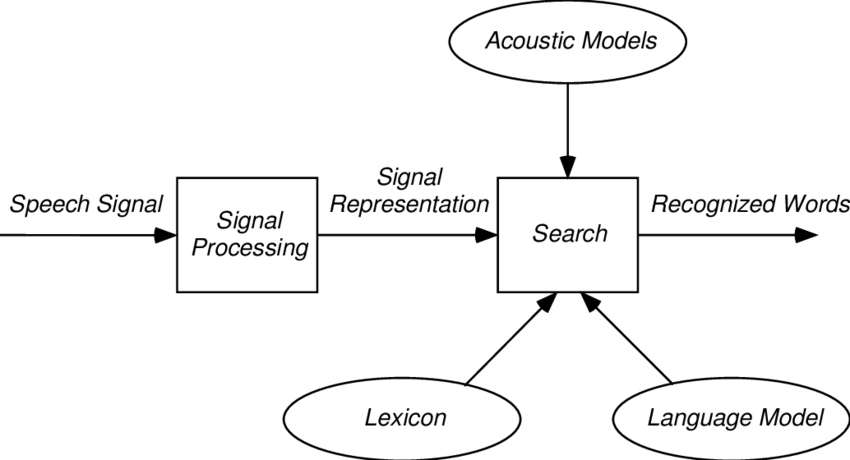

## Terminologies to remember

- Acoustic Model
- Language Model
- Vocabulary File
- Decoding and Search
- Alphabet file

# DeepSpeech

**DeepSpeech** is an open source Speech-To-Text engine, it is based on Baidu’s Deep Speech research paper and uses Tensorflow framework to build the neural networks that trains a speech recognition model. In this notebook, we will show you how to bring your own dataset to train an ASR model using Amazon SageMaker and DeepSpeech.


# Dataset

**Common Voice Corpus** an open source, multi-language dataset of voices that can be used to train and fine-tune automatic speech recognition models. It is one of the largest publicly available voice dataset of its kind and it is available for download from here https://commonvoice.mozilla.org/en/datasets

The dataset consists of a unique MP3 and corresponding text transcription file. Some of the recorded hours in the dataset also include demographic metadata like age, sex, and accent which can help train the accuracy of speech recognition engines.


### Dataset Format

The format of the dataset is quite simple but it is divided into multiple different components:

- You have the actual audio files in `.wav` format
- Training, Testing and Validated sets in `.csv` format
- all `.csv` files consist of three columns - audio file name, audio file size, actual transcriptions for each file.


# Training Preparation Steps:

In this step, we will generate the language model then build the scorer. The scorer is composed of two sub-components, a KenLM language model (https://github.com/kpu/kenlm) and a trie data structure that contains all the words in a vocabulary. In order to create the scorer package, we must create a KenLM language model (using data/lm/generate_lm.py, and then use generate_scorer_package to create the final package file including the trie data structure

The tools below are available in the pre-built binaries for the `deepspeech` command-line and can be downloaded from: https://github.com/mozilla/DeepSpeech/releases

**`generate_lm.py`** This is a script that will use the kenlm tools to build a language model from a corpus of text.

**`generate_scorer_package`** This is a binary that takes the alphabet of a language and a vocabulary file then generate a scorer package.

In [ ]:
!python3 data/lm/generate_lm.py --input_txt input.txt.gz --output_dir .   --top_k 500000 --kenlm_bins native_client/kenlm/build/bin/   --arpa_order 5 --max_arpa_memory "85%" --arpa_prune "0|0|1" --binary_a_bits 255 --binary_q_bits 8 --binary_type trie —discount_fallback

./generate_scorer_package --alphabet ./alphabet.txt --lm lm.binary --vocab vocab-500000.txt --package kenlm.scorer --default_alpha 0.6560092006459668 --default_beta 2.3034529727156823

# Building the Container

In [134]:
%%writefile docker/Dockerfile
# This docker file is following instructions from the official deepspeech docker.train.tmpl 
# available here https://github.com/mozilla/DeepSpeech/blob/master/Dockerfile.train.tmpl
FROM 763104351884.dkr.ecr.us-east-2.amazonaws.com/tensorflow-training:1.15.4-gpu-py37-cu100-ubuntu18.04 


ENV MOZILLA_VOICE_STT_REPO="https://github.com/mozilla/STT"
ENV MOZILLA_VOICE_STT_SHA="origin/master"

RUN apt-get update && apt-get install -y --no-install-recommends\
        apt-utils \
        bash-completion \
        build-essential \
        cmake \
        curl \
        git \
        libboost-all-dev \
        libbz2-dev \
        locales \
        python3-venv \
        unzip \
        wget
        
RUN apt-get install -y sox libsox-fmt-mp3
RUN apt-get purge -y python3-xdg

# Install dependencies for audio augmentation
RUN apt-get install -y --no-install-recommends libopus0 libsndfile1

# freeing some space
RUN rm -rf /var/lib/apt/lists/*; mkdir /opt/ml/

#Clone deepspeech library
WORKDIR /
RUN echo git clone $MOZILLA_VOICE_STT_REPO
RUN git clone $MOZILLA_VOICE_STT_REPO
RUN mv STT /opt/ml/code

#Setting the working directory of SageMaker
WORKDIR /opt/ml/code
RUN echo git checkout $MOZILLA_VOICE_STT_SHA
RUN git checkout $MOZILLA_VOICE_STT_SHA

# Build CTC decoder 
RUN cd native_client/ctcdecode && make NUM_PROCESSES=$(nproc) bindings
RUN pip3 install --upgrade native_client/ctcdecode/dist/*.whl

# Prepare deps
RUN pip3 install --upgrade pip==20.2.2 wheel==0.34.2 setuptools==49.6.0

# Install Mozilla Voice STT
#  - No need for the decoder since we did it earlier
#  - There is already correct TensorFlow GPU installed on the base image,
RUN DS_NODECODER=y DS_NOTENSORFLOW=y pip3 install --upgrade -e .

# Tool to convert output graph for inference
RUN python3 util/taskcluster.py --source tensorflow --branch r1.15 \
        --artifact convert_graphdef_memmapped_format  --target .

# Build KenLM to generate new scorers
WORKDIR /opt/ml/code/native_client
RUN rm -rf kenlm && \
        git clone https://github.com/kpu/kenlm && \
        cd kenlm && \
        git checkout 87e85e66c99ceff1fab2500a7c60c01da7315eec && \
        mkdir -p build && \
        cd build && \
        cmake .. && \
        make -j $(nproc)

RUN rm -rf /opt/ml/code/requirement* && rm -rf /opt/ml/code/setup.py

COPY start.py /opt/ml/code  
ENV PATH="/opt/ml/code:${PATH}"
WORKDIR /opt/ml/code/

# this environment variable is used by the SageMaker PyTorch container to determine our user code directory.
ENV TF_CUDNN_RESET_RND_GEN_STATE 1
ENV TF_FORCE_GPU_ALLOW_GROWTH True
ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
ENV SAGEMAKER_PROGRAM start.py

Overwriting docker/Dockerfile


# Building and Registering the Container
Alternatively, you can run the `build_and_push.sh` script from within the docker folder

In [133]:
%%sh

# The name of our algorithm
algorithm_name=deepspeech-arabic

cd docker

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Get the login command from ECR in order to pull down the SageMaker PyTorch image
$(aws ecr get-login --registry-ids 763104351884 --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} . --build-arg REGION=${region}
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded
Login Succeeded
Sending build context to Docker daemon  24.58kB
Step 1/30 : FROM 763104351884.dkr.ecr.us-east-2.amazonaws.com/tensorflow-training:1.15.4-gpu-py37-cu100-ubuntu18.04
 ---> ed601e8a8b58
Step 2/30 : ENV MOZILLA_VOICE_STT_REPO="https://github.com/mozilla/STT"
 ---> Using cache
 ---> 2b7eeee115c8
Step 3/30 : ENV MOZILLA_VOICE_STT_SHA="origin/master"
 ---> Using cache
 ---> 3246e7a10cdd
Step 4/30 : RUN apt-get update && apt-get install -y --no-install-recommends        apt-utils         bash-completion         build-essential         cmake         curl         git         libboost-all-dev         libbz2-dev         locales         python3-venv         unzip         wget
 ---> Using cache
 ---> 41f6a26ff23f
Step 5/30 : RUN apt-get install -y sox libsox-fmt-mp3
 ---> Using cache
 ---> 681642d2dfeb
Step 6/30 : RUN apt-get purge -y python3-xdg
 ---> Using cache
 ---> 46cd6a6d402f
Step 7/30 : RUN apt-get install -y --no-install-recommends libopus0 libsndfile1
 ---> 

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



## Import SageMaker libraries

In [2]:
# Import Sagemaker libraries
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import sagemaker

sess = sagemaker.Session()
role = get_execution_role()
bucket = 'sagemaker-ohio' #sagemaker.Session().default_bucket()
prefix = 'deepspeech-ar'

## Define Hyperparameters

In [82]:
hyperparameters = {
                   'drop_source_layers': 0,
                   'epochs': 200,
                   'train_batch_size': 128,
                   'test_batch_size': 128,
                   'early_stop': True,
                   'n_hidden': 2048,
                   'learning_rate': 0.0001,
                   'dropout_rate': 0.40,
                   'scorer': '/opt/ml/input/data/scorer/kenlm.scorer',
                   'augmentation': ['reverb[p=0.1,delay=50.0~30.0,decay=10.0:2.0~1.0]','resample[p=0.1,rate=12000:8000~4000]','codec[p=0.1,bitrate=48000:16000]','volume[p=0.1,dbfs=-10:-40]','pitch[p=0.1,pitch=1~0.2]','tempo[p=0.1,factor=1~0.5]','warp[p=0.1,nt=4,nf=1,wt=0.5:1.0,wf=0.1:0.2]','frequency_mask[p=0.1,n=1:3,size=1:5]','time_mask[p=0.1,domain=signal,n=3:10~2,size=50:100~40]','dropout[p=0.1,rate=0.05]','add[p=0.1,domain=signal,stddev=0~0.5]','multiply[p=0.1,domain=features,stddev=0~0.5]']
}

{'drop_source_layers': 0, 'epochs': 200, 'train_batch_size': 128, 'test_batch_size': 128, 'early_stop': True, 'n_hidden': 2048, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'scorer': '/opt/ml/input/data/scorer/kenlm.scorer', 'augmentation': ['reverb[p=0.1,delay=50.0~30.0,decay=10.0:2.0~1.0]', 'resample[p=0.1,rate=12000:8000~4000]', 'codec[p=0.1,bitrate=48000:16000]', 'volume[p=0.1,dbfs=-10:-40]', 'pitch[p=0.1,pitch=1~0.2]', 'tempo[p=0.1,factor=1~0.5]', 'warp[p=0.1,nt=4,nf=1,wt=0.5:1.0,wf=0.1:0.2]', 'frequency_mask[p=0.1,n=1:3,size=1:5]', 'time_mask[p=0.1,domain=signal,n=3:10~2,size=50:100~40]', 'dropout[p=0.1,rate=0.05]', 'add[p=0.1,domain=signal,stddev=0~0.5]', 'multiply[p=0.1,domain=features,stddev=0~0.5]']}


## Upload the Training, Test data, Scorer and Alphabet file

In [83]:
'''trainpath = sess.upload_data(
    path='./test.csv', bucket=bucket,
    key_prefix='deepspeech-ar/train')

vocabpath = sess.upload_data(
    path='./alphabet.txt', bucket=bucket,
    key_prefix='deepspeech-ar/vocab')'''

scorerpath = sess.upload_data(
    path='./kenlm.scorer', bucket=bucket,
    key_prefix='deepspeech-ar/scorer')

## Start Training

In [84]:
instance_type = 'ml.g4dn.12xlarge'
#instance_type = 'ml.p3.2xlarge'
#instance_type = 'ml.g4dn.xlarge'

#local training
#instance_type = 'local'

estimator = Estimator(role=role,
                      instance_count=1,
                      instance_type=instance_type,
                      image_uri='625616379791.dkr.ecr.us-east-2.amazonaws.com/deepspeech',
                      hyperparameters=hyperparameters,
                      disable_profiler=True)


train_config = sagemaker.inputs.TrainingInput('s3://{0}/{1}/{2}/'.format(bucket, prefix, 'train'))
test_config = sagemaker.inputs.TrainingInput('s3://{0}/{1}/{2}/'.format(bucket, prefix, 'test'))
#checkpoint_config = sagemaker.inputs.TrainingInput('s3://{0}/{1}/checkpoint/'.format(bucket, prefix))
vocab_file = sagemaker.inputs.TrainingInput('s3://{0}/{1}/vocab/'.format(bucket, prefix))
scorer_file = sagemaker.inputs.TrainingInput('s3://{0}/{1}/scorer/'.format(bucket, prefix))


print(train_config)
estimator.fit({'train': train_config, 'test': test_config, 'vocabulary': vocab_file, 'scorer': scorer_file})

2021-03-21 12:32:32 Starting - Starting the training job...
2021-03-21 12:32:34 Starting - Launching requested ML instances......
2021-03-21 12:33:38 Starting - Preparing the instances for training...
2021-03-21 12:34:26 Downloading - Downloading input data...............................................................................................................................................................
2021-03-21 13:01:10 Training - Downloading the training image..............WARNING:tensorflow:From /usr/local/lib/python3.7/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2021-03-21 13:03:18,085 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-03-21 13:03:18,085 sagemaker-training-toolkit INFO     Failed to parse hyperparameter scorer value /opt/ml/input/data/scorer/kenlm.scorer to Json.
Returning the value itself
2021-03-21 13:03:1

## Install Libraries for inference

In the next cell, we will install the deepspeech GPU library to make inference requests from the trained model.

In [71]:
!pip install deepspeech-gpu webrtcvad

     |████████████████████████████████| 66 kB 3.4 MB/s eta 0:00:011
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp36-cp36m-linux_x86_64.whl size=69948 sha256=5f37a0884d0e6e9d1021cb1dbbebf78825d09699d2273c2a15f0179390d95822
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ba/22/1c/d4e9707bbb27d469c384efc4263d8c7125219c1f088937289c
Successfully built webrtcvad


# Download the Model Graph

In [122]:
output_path = estimator.latest_training_job.describe()['ModelArtifacts']['S3ModelArtifacts']
!aws s3 cp $output_path ./; tar -xvzf model.tar.gz

download: s3://sagemaker-us-east-2-625616379791/deepspeech-2021-03-21-12-32-32-432/output/model.tar.gz to ./model.tar.gz
author_model_0.0.1.md
output_graph.pb


## Loading Trained Model

In [126]:
import glob
import webrtcvad
import logging
import wavSplit
from deepspeech import Model
from timeit import default_timer as timer


#Load the pre-trained model into the memory

def load_model(models, scorer):
    model_load_start = timer()
    ds = Model(models)
    model_load_end = timer() - model_load_start
    logging.debug("Loaded model in %0.3fs." % (model_load_end))

    scorer_load_start = timer()
    ds.enableExternalScorer(scorer)
    scorer_load_end = timer() - scorer_load_start
    logging.debug('Loaded external scorer in %0.3fs.' % (scorer_load_end))

    return [ds, model_load_end, scorer_load_end]

def vad_segment_generator(wavFile, aggressiveness):
    logging.debug("Caught the wav file @: %s" % (wavFile))
    audio, sample_rate, audio_length = wavSplit.read_wave(wavFile)
    assert sample_rate == 16000,
    vad = webrtcvad.Vad(int(aggressiveness))
    frames = wavSplit.frame_generator(30, audio, sample_rate)
    frames = list(frames)
    segments = wavSplit.vad_collector(sample_rate, 30, 300, vad, frames)

    return segments, sample_rate, audio_length

def stt(ds, audio, fs):
    inference_time = 0.0
    audio_length = len(audio) * (1 / fs)

    # Run Deepspeech
    logging.debug('Running inference...')
    inference_start = timer()
    output = ds.stt(audio)
    inference_end = timer() - inference_start
    inference_time += inference_end
    logging.debug('Inference took %0.3fs for %0.3fs audio file.' % (inference_end, audio_length))

    return [output, inference_time]

#Loading the trained ASR model
model = load_model('output_graph.pb', 'kenlm.scorer')

## Segment Audio file

In [127]:
filename = 'common_voice_ar_19058555.wav'
segments, sample_rate, audio_length = vad_segment_generator(filename,3)

## Make an inference request

In [128]:
import numpy as np
inference_time = 0.0
for i, segment in enumerate(segments):
            # Run deepspeech on the chunk that just completed VAD
            logging.debug("Processing chunk %002d" % (i,))
            audio = np.frombuffer(segment, dtype=np.int16)
            output = stt(model[0], audio, sample_rate)
            inference_time += output[1]
            logging.debug("Transcript: %s" % output[0])

            print(output[0] + " ")


بنا على تجاه الذي سار فيه أظن أنه كان متجها إلى بدا 


# Next Steps:
- Build a SageMaker Inference (WIP)
- Include steps to optimize inference requests (tuning lm_alpha and lm_beta values involved in creating scorer) (WIP)
- Multi-instance GPU training (WIP)
- Support fine tuning.
- Support transfer learning.
- Add steps to create alphabet, vocab files for any language.